# Phase II: Data Curation, Exploratory Analysis and Plotting
We plan on using [U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics' 2015 Flight Delays and Cancellations dataset from Kaggle](https://www.kaggle.com/datasets/usdot/flight-delays) which contains airline data, airport data, and detailed flight data from 2015.

Using these data, we want to determine:
1. What causes or correlations (time of travel, weather, etc) we can link to delays and cancellations — can we make predictions or improve these?
2. What causes or correlations can we link to accidents? How can we use these to improve air travel safety?

## Data Collection

This dataset can be imported from Kaggle using the [Kaggle Hub Client Library](https://github.com/Kaggle/kagglehub) which makes it easy to import the data for use with Pandas DataFrames.

In [2]:
! pip install kagglehub
import kagglehub
path = kagglehub.dataset_download("usdot/flight-delays")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 KB 6.1 MB/s eta 0:00:00


/Users/boqiangliang/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 191M/191M [00:10<00:00, 19.1MB/s] 

Extracting files...


In [3]:
import pandas as pd

airlines_df = pd.read_csv(path + "/airlines.csv", low_memory=False, encoding='UTF-8')
airports_df = pd.read_csv(path + "/airports.csv", low_memory=False, encoding='UTF-8')
flights_df = pd.read_csv(path + "/flights.csv", low_memory=False, encoding='UTF-8')

## Data Cleanup

Merges the 3 DataFrames together, first by removing their file name prefixes from the column names. Then, by adding in airport information for both the origin and destination airport (merges the Airports DF twice technically), and then joins the airlines table with the flights table. Lastly, we create a datetime object from the existing date columns

In [4]:
# Remove file name prefix from column names
airlines_df.columns = airlines_df.columns.str.replace(r'^airlines\.csv/', '', regex=True)
airlines_df.rename(columns={'AIRLINE': 'AIRLINE NAME'}, inplace=True)

airports_df.columns = airports_df.columns.str.replace(r'^airports\.csv/', '', regex=True)

flights_df.columns = flights_df.columns.str.replace(r'^flights\.csv/', '', regex=True)

In [5]:
# Join airports data to flights table
origin_airports = airports_df.add_prefix('origin_airport/')
destination_airports = airports_df.add_prefix('destination_airport/')

flights_df = flights_df.join(origin_airports.set_index('origin_airport/IATA_CODE'), on='ORIGIN_AIRPORT')
flights_df = flights_df.join(destination_airports.set_index('destination_airport/IATA_CODE'), on='DESTINATION_AIRPORT')

In [6]:
# Join airlines data to flights table
flights_df = flights_df.join(airlines_df.set_index('IATA_CODE'), on='AIRLINE')

In [7]:
# Create DATE column from YEAR, MONTH, DAY, and SCHEDULED_DEPARTURE columns
flights_df['DATE'] = pd.to_datetime(
    flights_df['YEAR'].astype(str) + '-' +
    flights_df['MONTH'].astype(str) + '-' +
    flights_df['DAY'].astype(str) + ' ' +
    flights_df['SCHEDULED_DEPARTURE'].astype(str).str.zfill(4),
    format='%Y-%m-%d %H%M'
)

In [8]:
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,origin_airport/LATITUDE,origin_airport/LONGITUDE,destination_airport/AIRPORT,destination_airport/CITY,destination_airport/STATE,destination_airport/COUNTRY,destination_airport/LATITUDE,destination_airport/LONGITUDE,AIRLINE NAME,DATE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,61.17432,-149.99619,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,Alaska Airlines Inc.,2015-01-01 00:05:00
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,33.94254,-118.40807,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559,American Airlines Inc.,2015-01-01 00:10:00
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,37.61900,-122.37484,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,US Airways Inc.,2015-01-01 00:20:00
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,33.94254,-118.40807,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,American Airlines Inc.,2015-01-01 00:20:00
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,47.44898,-122.30931,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,Alaska Airlines Inc.,2015-01-01 00:25:00


## Data Visualization

In [10]:
! pip install altair
! pip install seaborn
! pip install matplotlib
! pip plotly
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

alt.data_transformers.disable_max_rows()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 KB 4.2 MB/s eta 0:00:00a 0:00:01
  Using cached jinja2-3.1.5-py3-none-any.whl (134 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.9/308.9 KB 4.4 MB/s eta 0:00:00a 0:00:01
  Using cached MarkupSafe-3.0.2-cp310-cp310-macosx_11_0_arm64.whl (12 kB)
ERROR: unknown command "plotly"


DataTransformerRegistry.enable('default')

In [58]:
! pip install geopandas
! pip install shapely
! pip install contextily
import geopandas as gpd
from shapely.geometry import Point, box
import contextily as ctx

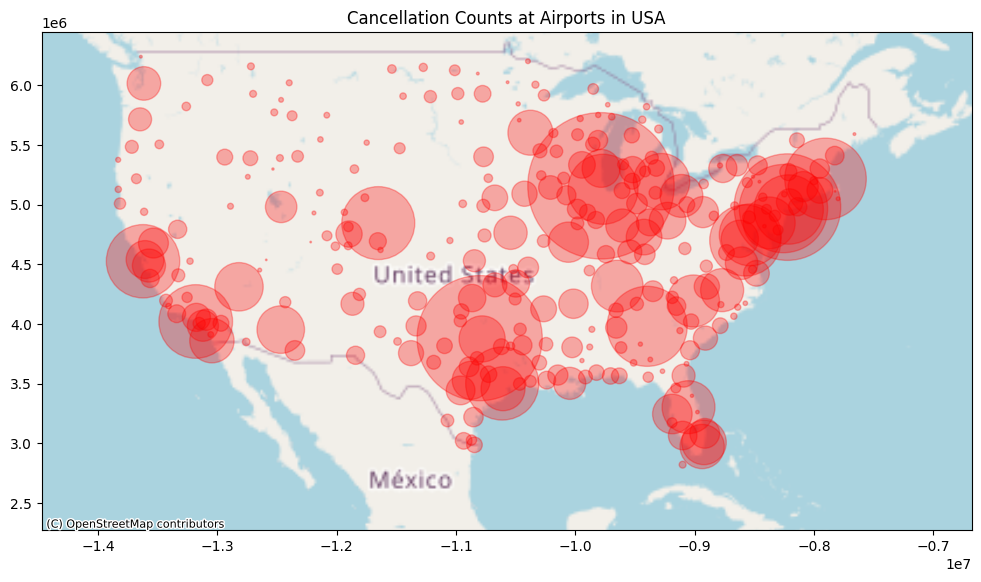

In [73]:
# 1. What causes or correlations (time of travel, weather, etc) we can link to delays and
# cancellations — can we make predictions or improve these?


# Filter for cancelled departures
cancelled = flights_df[flights_df['CANCELLED']==1]


agg = cancelled.groupby(['ORIGIN_AIRPORT', 'origin_airport/LATITUDE', 'origin_airport/LONGITUDE']).size().reset_index(name='cancellations')               

point = []

for idx in range(len(agg)):
    longitude = agg['origin_airport/LONGITUDE'].iloc[idx]
    latitude = agg['origin_airport/LATITUDE'].iloc[idx]
    point.append(Point(longitude, latitude))


agg['geometry'] = point
agg.head()

# set coordinate reference to USA and google maps
gdf = gpd.GeoDataFrame(agg, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)

# Reproject to Web Mercator for contextily
gdf_3857 = gdf.to_crs(epsg=3857)



# Bounding box for USA, so we see the ones in USA only
bbox = box(-130, 20, -60, 50)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='epsg:4326')
bbox_3857 = bbox_gdf.to_crs(epsg=3857)


# Get the bounds (xmin, ymin, xmax, ymax)
xmin, ymin, xmax, ymax = bbox_3857.total_bounds

# This is just making the whole plot. 
fig, ax = plt.subplots(figsize=(12, 8))

# the dots are the cancellation counts. higher concentration means more cancellations.
gdf_3857.plot(ax=ax, markersize=gdf_3857['cancellations']*1.3, color='red', alpha=0.3)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# And also this is just
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("Cancellation Counts at Airports in USA")
plt.show()

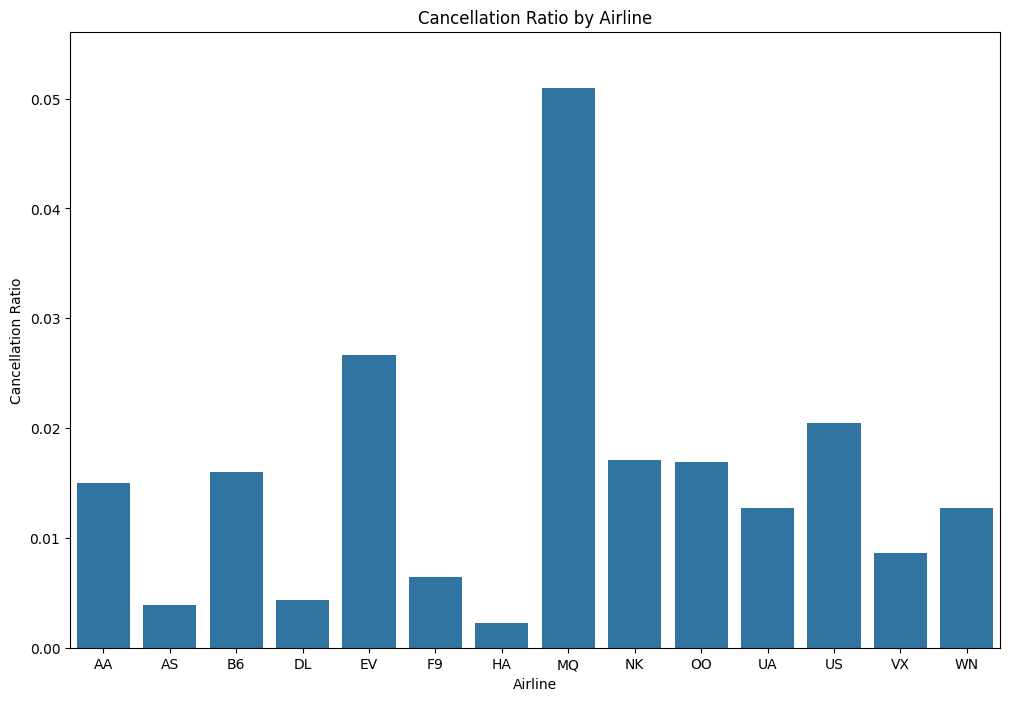

In [20]:
# Compute cancellation ratio per airline and create a bar chart
agg_flights = flights_df.groupby('AIRLINE').agg(cancel_ratio=('CANCELLED', 'mean')).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=agg_flights, x='AIRLINE', y='cancel_ratio')
plt.xlabel("Airline")
plt.ylabel("Cancellation Ratio")
plt.title("Cancellation Ratio by Airline")
plt.ylim(0, agg_flights['cancel_ratio'].max() * 1.1)
plt.show()